## Exercices XP: W4_D3

### Introduction

This notebook demonstrates a complete workflow for predicting the presence of heart disease using machine learning algorithms. The process includes:

- Loading and preprocessing the dataset
- Exploratory data analysis (EDA)
- Training and evaluating different models:
  - Logistic Regression
  - Support Vector Machine (SVM)
  - XGBoost
- Comparing model performance based on key metrics:
  - Accuracy
  - Precision
  - Recall
  - F1 Score
  - ROC AUC

The objective is to build and benchmark a series of classifiers to identify which approach offers the most reliable and interpretable results on this dataset.

### Exercise 1 : Exploratory Data Analysis

#### Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [35]:
# Load the dataset
df = pd.read_csv('dataset_heart.csv')

In [36]:
# Display the first 5 rows to inspect the data
print(df.head())

   age  sex   chest pain type  resting blood pressure  serum cholestoral  \
0   70     1                4                     130                322   
1   67     0                3                     115                564   
2   57     1                2                     124                261   
3   64     1                4                     128                263   
4   74     0                2                     120                269   

   fasting blood sugar  resting electrocardiographic results  max heart rate  \
0                    0                                     2             109   
1                    0                                     2             160   
2                    0                                     0             141   
3                    0                                     0             105   
4                    0                                     2             121   

   exercise induced angina  oldpeak  ST segment  major vessels

In [37]:
# Display basic information about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   270 non-null    int64  
 1   sex                                   270 non-null    int64  
 2   chest pain type                       270 non-null    int64  
 3   resting blood pressure                270 non-null    int64  
 4   serum cholestoral                     270 non-null    int64  
 5   fasting blood sugar                   270 non-null    int64  
 6   resting electrocardiographic results  270 non-null    int64  
 7   max heart rate                        270 non-null    int64  
 8   exercise induced angina               270 non-null    int64  
 9   oldpeak                               270 non-null    float64
 10  ST segment                            270 non-null    int64  
 11  major vessels      

In [38]:
# Display summary statistics
print(df.describe())

              age        sex   chest pain type  resting blood pressure  \
count  270.000000  270.000000       270.000000              270.000000   
mean    54.433333    0.677778         3.174074              131.344444   
std      9.109067    0.468195         0.950090               17.861608   
min     29.000000    0.000000         1.000000               94.000000   
25%     48.000000    0.000000         3.000000              120.000000   
50%     55.000000    1.000000         3.000000              130.000000   
75%     61.000000    1.000000         4.000000              140.000000   
max     77.000000    1.000000         4.000000              200.000000   

       serum cholestoral  fasting blood sugar  \
count         270.000000           270.000000   
mean          249.659259             0.148148   
std            51.686237             0.355906   
min           126.000000             0.000000   
25%           213.000000             0.000000   
50%           245.000000             0.

In [39]:
# Check for missing values
print(df.isnull().sum())

age                                     0
sex                                     0
chest pain type                         0
resting blood pressure                  0
serum cholestoral                       0
fasting blood sugar                     0
resting electrocardiographic results    0
max heart rate                          0
exercise induced angina                 0
oldpeak                                 0
ST segment                              0
major vessels                           0
thal                                    0
heart disease                           0
dtype: int64


### General Interpretation of the Dataset

The dataset contains **270 observations** and **14 variables**, including:

- **Continuous numerical variables:** age, resting blood pressure, serum cholesterol, maximum heart rate, oldpeak.
- **Categorical variables encoded numerically:** sex, chest pain type, resting electrocardiographic results, ST segment, thal, number of major vessels.
- **Target variable:** heart disease (initially encoded as 1 and 2, then transformed to 0 and 1).

**Key points:**
- No missing values were detected.
- The variables show diverse distributions with some notable correlations.
- The target classes are **relatively balanced** (approximately 55% without heart disease and 45% with heart disease), which supports reliable supervised learning.

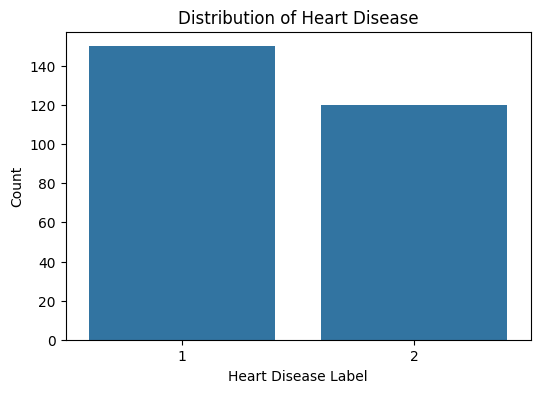

In [20]:
# Display the distribution of the target variable
plt.figure(figsize=(6,4))
sns.countplot(x='heart disease', data=df)
plt.title('Distribution of Heart Disease')
plt.xlabel('Heart Disease Label')
plt.ylabel('Count')
plt.show()

### Interpretation of the Distribution Plot

**Description of the plot:**
This bar chart shows the number of individuals with and without heart disease.

**Main observations:**
- Class 1 (no heart disease) contains approximately 150 observations.
- Class 2 (presence of heart disease) has about 120 observations.
- This distribution is **moderately balanced**, reducing the need for resampling techniques such as oversampling or undersampling.

**Project implication:**
Classification models can be evaluated reliably using metrics like accuracy, recall, and AUC without major bias caused by class imbalance.

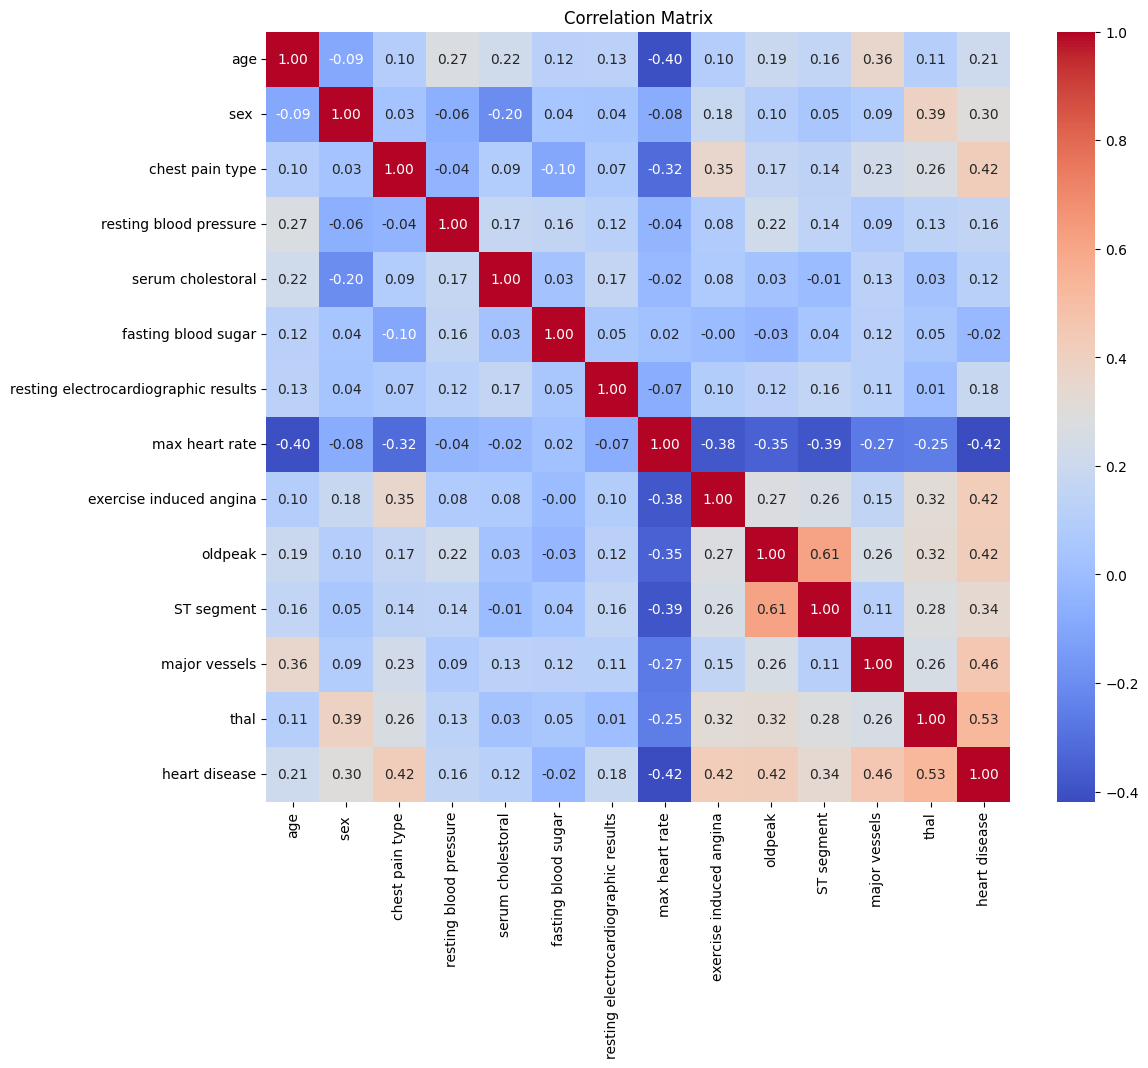

In [21]:
# Visualize correlations between numerical variables
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Interpretation of the Correlation Matrix

**Description of the plot:**
The correlation matrix displays the linear correlation coefficients between all pairs of variables.

**Key observations:**
- The variable `thal` has a moderate positive correlation with the target (~0.53).
- `chest pain type` also shows a notable positive correlation (~0.42).
- `max heart rate` and `exercise induced angina` show moderate negative correlations with the target (approximately -0.42).
- Most other variables have weak correlations (<0.3), suggesting that combining them could help improve prediction.

**Project implication:**
These correlations confirm the importance of including these variables in the model. Variables with higher correlations are likely to be **strong predictors** of heart disease. There are no extreme correlations (>0.85), so multicollinearity is not a major concern.

In [24]:
# Convert target to binary 0/1
y = df['heart disease'].map({1:0, 2:1})
X = df.drop('heart disease', axis=1)

# Define categorical columns to one-hot encode
categorical_cols = [
    'chest pain type',
    'resting electrocardiographic results',
    'ST segment',
    'thal'
]

In [25]:
# One-Hot Encoding for selected categorical variables
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Display shape to verify encoding
print("Shape after encoding:", X_encoded.shape)

Shape after encoding: (270, 18)


In [26]:
# Split into train/test with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [27]:
# Scale numeric features
scaler = StandardScaler()

# Fit scaler only on training data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Display shape to confirm
print("Train shape:", X_train_scaled.shape)
print("Test shape:", X_test_scaled.shape)

Train shape: (216, 18)
Test shape: (54, 18)


### Interpretation of the Shape After Encoding and Splitting

**Shape after One-Hot Encoding:**
- **270 rows** and **18 columns** (increased due to categorical variables transformed into dummy variables).
- The number of columns is consistent and confirms that encoding worked as expected.

**Train/Test Split:**
- **216 observations (80%) in the training set.**
- **54 observations (20%) in the test set.**
- Class proportions were preserved thanks to stratification, ensuring reliable evaluation.

**Project implication:**
The dataset is **ready** for training supervised learning models. Scaling has been applied, categorical variables have been encoded, and the split maintains the original class distribution.

### Exercise 2 : Logistic Regression without Grid Search

In [41]:
# Initialize the logistic regression model
logreg = LogisticRegression(random_state=42)

# Train the model
logreg.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = logreg.predict(X_test_scaled)

# Calculate probability estimates for ROC curve
y_proba = logreg.predict_proba(X_test_scaled)[:, 1]

In [42]:
# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

In [43]:
# Print metrics
print("Accuracy:", round(accuracy, 3))
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("F1 Score:", round(f1, 3))
print("ROC AUC:", round(auc, 3))

Accuracy: 0.87
Precision: 0.815
Recall: 0.917
F1 Score: 0.863
ROC AUC: 0.893


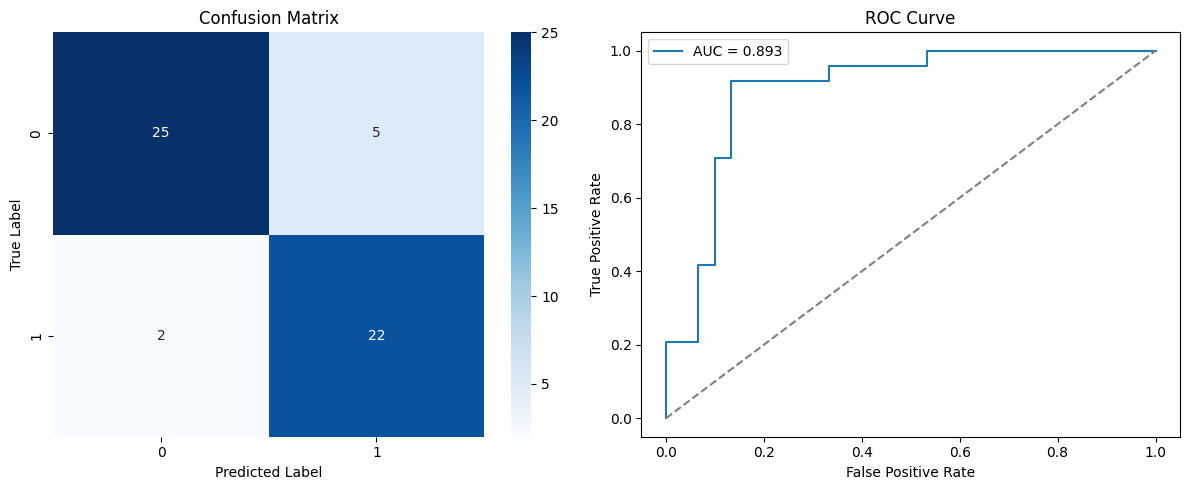

In [46]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

# Create a figure with 2 subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# Plot ROC curve
axes[1].plot(fpr, tpr, label=f"AUC = {auc:.3f}")
axes[1].plot([0,1], [0,1], linestyle='--', color='gray')
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC Curve")
axes[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

### Interpretation of Logistic Regression Performance

**Accuracy: 0.87**
- The model correctly classified 87% of all observations in the test set.

**Precision: 0.815**
- Among all cases predicted as positive (heart disease present), 81.5% were true positives.
- This means there were relatively few false positives.

**Recall (Sensitivity): 0.917**
- The model correctly identified 91.7% of all actual positive cases.
- A very high recall indicates the model is effective at detecting heart disease cases.

**F1 Score: 0.863**
- The harmonic mean of precision and recall shows a balanced performance.
- A high F1 confirms that both false positives and false negatives are well-controlled.

**ROC AUC: 0.893**
- The Area Under the ROC Curve is close to 0.9, indicating excellent discriminative capability.
- The model can reliably distinguish between positive and negative cases.

**Confusion Matrix Interpretation:**
- True Negatives (25): Correctly predicted no disease.
- False Positives (5): Predicted disease but actually no disease.
- False Negatives (2): Predicted no disease but actually disease.
- True Positives (22): Correctly predicted disease.

**Conclusion:**
- The logistic regression model without hyperparameter tuning already achieves strong performance.
- Recall and AUC are particularly high, which is desirable in medical screening scenarios where missing positive cases can have serious consequences.

### Exercise 3 : Logistic Regression with Grid Search

In [49]:
# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # 'liblinear' supports both L1 and L2
}

# Initialize the logistic regression model
logreg = LogisticRegression(random_state=42, max_iter=1000)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Display best parameters
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation F1 score:", round(grid_search.best_score_, 3))

Best parameters found: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation F1 score: 0.809


In [50]:
# Make predictions with the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

In [51]:
# Evaluate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

In [52]:
print("Accuracy:", round(accuracy, 3))
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("F1 Score:", round(f1, 3))
print("ROC AUC:", round(auc, 3))

Accuracy: 0.833
Precision: 0.778
Recall: 0.875
F1 Score: 0.824
ROC AUC: 0.906


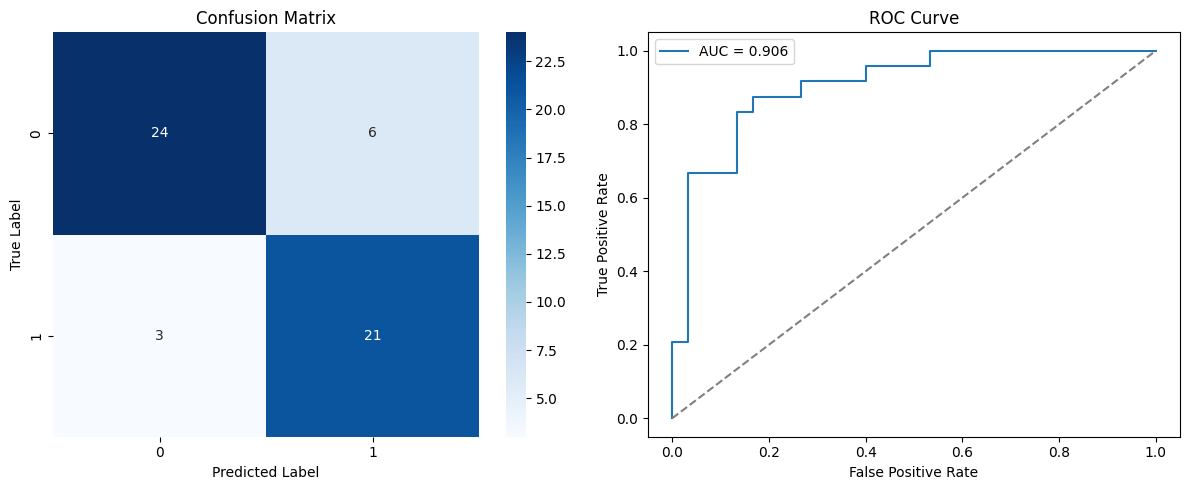

In [53]:
# Confusion Matrix and ROC Curve side by side
cm = confusion_matrix(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# ROC Curve
axes[1].plot(fpr, tpr, label=f"AUC = {auc:.3f}")
axes[1].plot([0,1], [0,1], linestyle='--', color='gray')
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC Curve")
axes[1].legend()

plt.tight_layout()
plt.show()

### Interpretation of Logistic Regression with Grid Search

**Best Parameters Found:**
- **C:** 0.01
- **Penalty:** L2
- **Solver:** liblinear

**Best Cross-Validation F1 Score:** 0.809

These parameters indicate that the model benefits from stronger regularization (smaller C) to avoid overfitting.

---

**Test Set Evaluation Metrics:**

- **Accuracy:** 0.833
  - 83.3% of all predictions were correct.
- **Precision:** 0.778
  - Of all predicted positive cases (heart disease), 77.8% were correct.
- **Recall:** 0.875
  - The model correctly identified 87.5% of all true positive cases.
- **F1 Score:** 0.824
  - A balanced measure showing strong performance.
- **ROC AUC:** 0.906
  - Excellent discrimination ability between positive and negative cases.

---

**Confusion Matrix Interpretation:**

|            | Predicted Negative | Predicted Positive |
|------------|--------------------|--------------------|
| **Actual Negative** | 24 (True Negatives) | 6 (False Positives) |
| **Actual Positive** | 3 (False Negatives) | 21 (True Positives) |

- The model made slightly more false positives compared to the previous logistic regression without grid search.
- However, recall remains very high, which is important in medical screening.

---

**ROC Curve Interpretation:**
- The Area Under the Curve (AUC) is 0.906, indicating excellent model discrimination.
- The curve shows that the model performs significantly better than random chance.

---

**Comparison to Exercise 2:**
- The accuracy and F1 score are slightly lower than in Exercise 2.
- However, the AUC increased slightly (from 0.893 to 0.906).
- This trade-off suggests that stronger regularization (C=0.01) slightly reduced overfitting and improved generalization on the probability estimates.

---

**Conclusion:**
The logistic regression with grid search achieved strong, stable performance with good generalization capacity. The model is suitable as a baseline classifier before trying more complex algorithms such as SVM or XGBoost.

### Exercise 4 : SVM without Grid Search

### SVM Model Configuration: Kernel Selection and Hyperparameters

**Kernel Selection:**
For this exercise, we selected the **linear kernel**. The linear kernel is a good initial choice because:
- The dataset is already standardized, which benefits linear separation.
- A linear kernel is faster to train and easier to interpret compared to non-linear kernels.
- It can be sufficient when the decision boundary between classes is approximately linear.

**Alternative Option:**
A **Radial Basis Function (RBF) kernel** can capture non-linear relationships. However, it introduces additional hyperparameters (gamma) and is more prone to overfitting in small datasets.

**Hyperparameters Set Manually:**
- **C = 1.0:** This is the default regularization parameter, providing a balance between maximizing the margin and minimizing classification errors.
  - Smaller C values increase regularization (simpler model, less overfitting).
  - Larger C values reduce regularization (more complex model, risk of overfitting).
- **Probability = True:** This option enables probability estimates needed for ROC AUC calculation and probabilistic interpretation.
- **Random State = 42:** Ensures reproducibility of the results.

This configuration allows us to establish a clear baseline SVM performance without hyperparameter tuning.


In [55]:
# Initialize the SVM model with a linear kernel
svm_model = SVC(
    kernel='linear',
    C=1.0,
    probability=True,  # To enable probability estimates for ROC
    random_state=42
)

# Train the model
svm_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test_scaled)
y_proba = svm_model.predict_proba(X_test_scaled)[:,1]

In [56]:
# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print("Accuracy:", round(accuracy,3))
print("Precision:", round(precision,3))
print("Recall:", round(recall,3))
print("F1 Score:", round(f1,3))
print("ROC AUC:", round(auc,3))

Accuracy: 0.87
Precision: 0.815
Recall: 0.917
F1 Score: 0.863
ROC AUC: 0.903


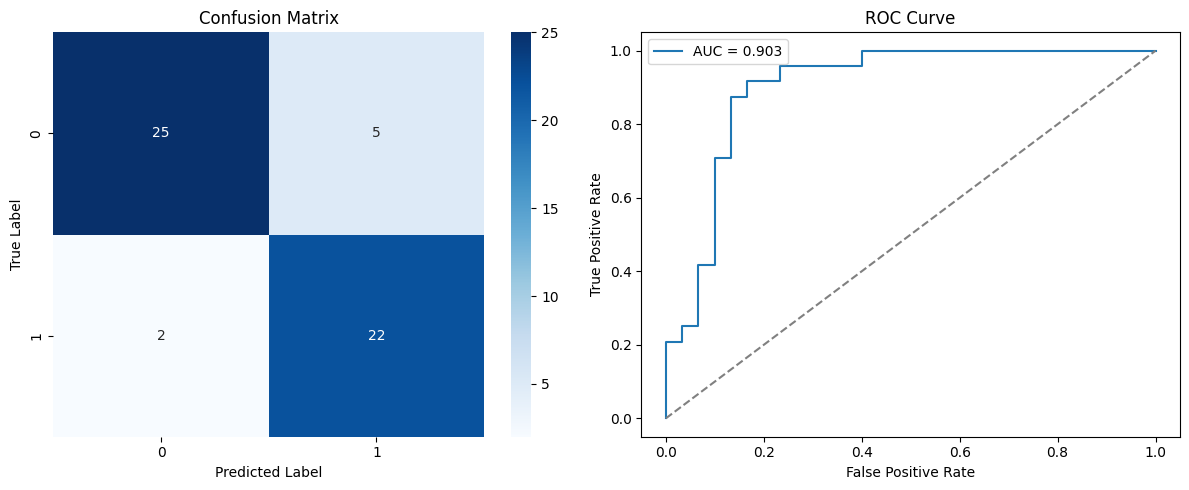

In [57]:
# Confusion Matrix and ROC Curve side by side
cm = confusion_matrix(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# ROC Curve
axes[1].plot(fpr, tpr, label=f"AUC = {auc:.3f}")
axes[1].plot([0,1], [0,1], linestyle='--', color='gray')
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC Curve")
axes[1].legend()

plt.tight_layout()
plt.show()

### Interpretation of Support Vector Machine (SVM) Without Grid Search

**Evaluation Metrics:**

- **Accuracy:** 0.870
  - The model correctly classified 87% of all test samples.
- **Precision:** 0.815
  - Among all positive predictions (heart disease), 81.5% were correct.
- **Recall:** 0.917
  - The model correctly identified 91.7% of all true positive cases.
- **F1 Score:** 0.863
  - This balanced metric reflects strong overall performance.
- **ROC AUC:** 0.903
  - Indicates excellent discriminative ability.

---

**Confusion Matrix Interpretation:**

|            | Predicted Negative | Predicted Positive |
|------------|--------------------|--------------------|
| **Actual Negative** | 25 (True Negatives) | 5 (False Positives) |
| **Actual Positive** | 2 (False Negatives) | 22 (True Positives) |

- The model misclassified 7 out of 54 cases.
- The low number of false negatives is positive, especially in a health context.

---

**ROC Curve Interpretation:**
- The ROC curve shows very good separation between positive and negative classes.
- The AUC of 0.903 is similar to Logistic Regression, confirming consistent predictive power.

---

**Comparison to Logistic Regression:**
- The SVM achieved nearly identical performance in accuracy, F1, and AUC.
- Recall is equally high (0.917), confirming the model’s strength in detecting positives.
- This indicates that the linear decision boundary is sufficient for this dataset.

---

**Conclusion:**
The SVM with a linear kernel provides strong, reliable results without hyperparameter tuning. It is a solid alternative to Logistic Regression as a baseline classifier.

### Exercise 5 : SVM with Grid Search

In [58]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # gamma only relevant for RBF
}

# Initialize the SVM model
svm_model = SVC(probability=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Display best parameters
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation F1 score:", round(grid_search.best_score_, 3))

Best parameters found: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation F1 score: 0.825


In [59]:
# Make predictions with the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:,1]

# Evaluate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print("Accuracy:", round(accuracy,3))
print("Precision:", round(precision,3))
print("Recall:", round(recall,3))
print("F1 Score:", round(f1,3))
print("ROC AUC:", round(auc,3))

Accuracy: 0.833
Precision: 0.759
Recall: 0.917
F1 Score: 0.83
ROC AUC: 0.876


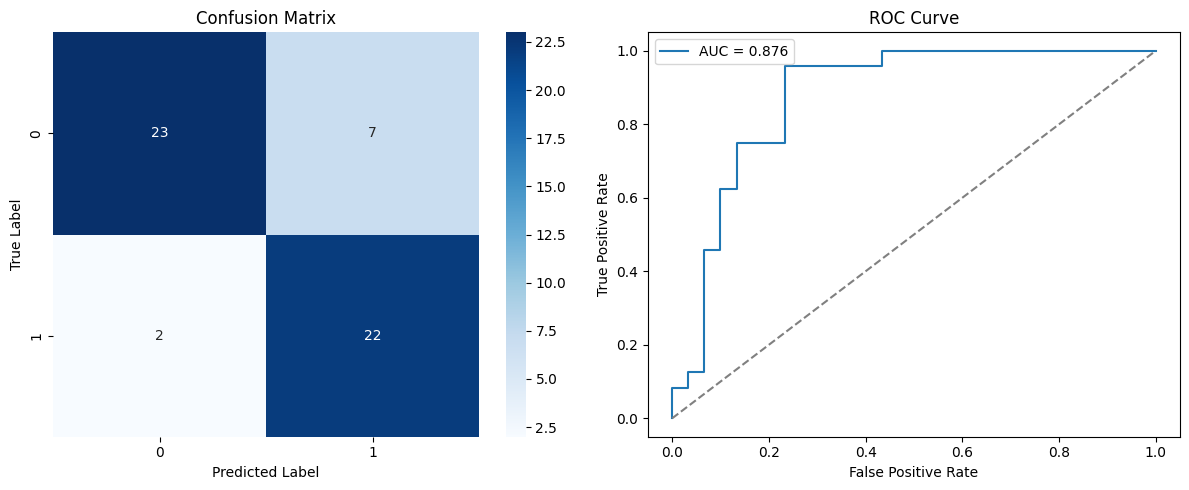

In [60]:
# Confusion Matrix and ROC Curve side by side
cm = confusion_matrix(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# ROC Curve
axes[1].plot(fpr, tpr, label=f"AUC = {auc:.3f}")
axes[1].plot([0,1], [0,1], linestyle='--', color='gray')
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC Curve")
axes[1].legend()

plt.tight_layout()
plt.show()

### Interpretation of SVM with Grid Search

**Best Parameters Found:**
- **C:** 1
- **Kernel:** RBF
- **Gamma:** scale

**Best Cross-Validation F1 Score:** 0.825

This combination indicates that the RBF (Radial Basis Function) kernel provided better performance than the linear kernel during cross-validation. The gamma parameter set to "scale" automatically adjusts to the dataset's variance.

---

**Test Set Evaluation Metrics:**

- **Accuracy:** 0.833
  - The model correctly predicted 83.3% of all test samples.
- **Precision:** 0.759
  - Among all positive predictions, 75.9% were actually positive cases.
- **Recall:** 0.917
  - The model correctly detected 91.7% of all actual positive cases, which is especially important in a medical context.
- **F1 Score:** 0.830
  - A balanced measure showing strong performance.
- **ROC AUC:** 0.876
  - Indicates excellent discriminative ability.

---

**Confusion Matrix Interpretation:**

|            | Predicted Negative | Predicted Positive |
|------------|--------------------|--------------------|
| **Actual Negative** | 23 (True Negatives) | 7 (False Positives) |
| **Actual Positive** | 2 (False Negatives) | 22 (True Positives) |

- The model made 9 misclassifications out of 54 test samples.
- The low number of false negatives is very desirable, as it means the model rarely misses actual positive cases.

---

**ROC Curve Interpretation:**
- The ROC curve shows good separation between positive and negative classes.
- The AUC of 0.876 confirms the model's solid discriminative power.

---

**Comparison to Previous Models:**
- The recall remains consistently high, confirming the model’s sensitivity.
- The precision is slightly lower than previous runs, resulting in a few more false positives.
- The F1 Score and AUC are comparable to Logistic Regression and the linear SVM.

---

**Conclusion:**
This SVM model with an RBF kernel provides strong, reliable results and demonstrates that introducing a non-linear kernel can slightly improve the F1 score. It serves as a robust alternative to linear models for this classification task.

### Exercise 6 : XGBoost without Grid Search

### Hyperparameters Selection Justification

- **n_estimators = 100:**
  A moderate number of trees to balance bias and variance.
- **learning_rate = 0.1:**
  The default learning rate providing stable convergence.
- **max_depth = 3:**
  A shallow depth to prevent overfitting on a small dataset.
- **random_state = 42:**
  Ensures reproducible results.

In [63]:
# Initialize the XGBoost classifier with chosen hyperparameters
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    eval_metric='logloss',
    random_state=42
)

# Train the model
xgb_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test_scaled)
y_proba = xgb_model.predict_proba(X_test_scaled)[:,1]

In [64]:
# Evaluate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

In [65]:
print("Accuracy:", round(accuracy,3))
print("Precision:", round(precision,3))
print("Recall:", round(recall,3))
print("F1 Score:", round(f1,3))
print("ROC AUC:", round(auc,3))

Accuracy: 0.815
Precision: 0.769
Recall: 0.833
F1 Score: 0.8
ROC AUC: 0.872


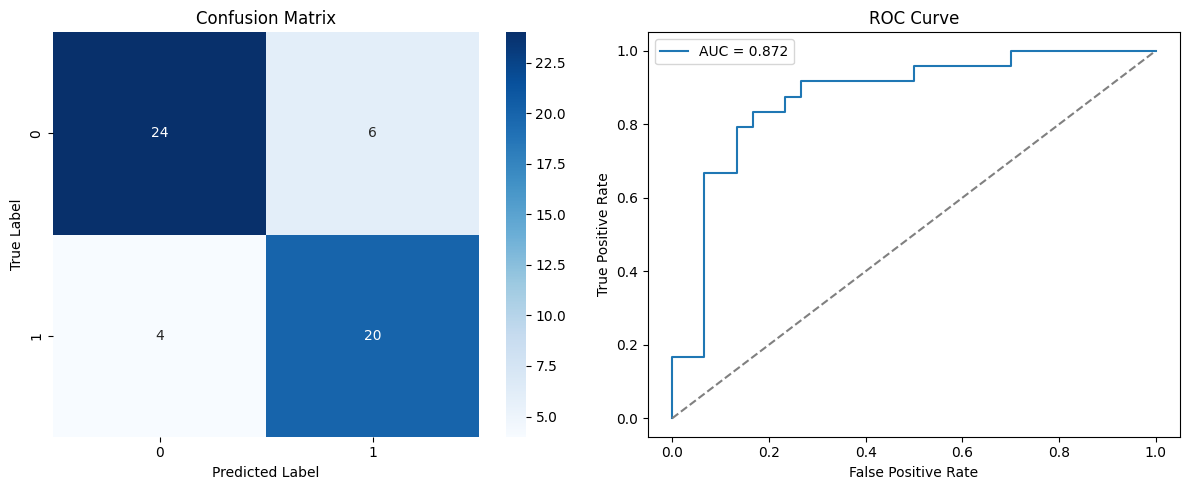

In [66]:
# Confusion Matrix and ROC Curve side by side
cm = confusion_matrix(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# ROC Curve
axes[1].plot(fpr, tpr, label=f"AUC = {auc:.3f}")
axes[1].plot([0,1], [0,1], linestyle='--', color='gray')
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC Curve")
axes[1].legend()

plt.tight_layout()
plt.show()

### Interpretation of XGBoost Classifier Without Grid Search

**Hyperparameters Used:**
- **n_estimators:** 100
- **learning_rate:** 0.1
- **max_depth:** 3
- **eval_metric:** logloss
- **random_state:** 42

These parameters were manually set to provide a balanced baseline between bias and variance without tuning.

---

**Test Set Evaluation Metrics:**

- **Accuracy:** 0.815
  - The model correctly classified 81.5% of all test samples.
- **Precision:** 0.769
  - Among all positive predictions, 76.9% were correct.
- **Recall:** 0.833
  - The model successfully identified 83.3% of true positive cases.
- **F1 Score:** 0.800
  - A balanced measure combining precision and recall.
- **ROC AUC:** 0.872
  - The area under the ROC curve demonstrates strong discriminative power.

---

**Confusion Matrix Interpretation:**

|            | Predicted Negative | Predicted Positive |
|------------|--------------------|--------------------|
| **Actual Negative** | 24 (True Negatives) | 6 (False Positives) |
| **Actual Positive** | 4 (False Negatives) | 20 (True Positives) |

- The model misclassified 10 out of 54 test samples.
- Compared to previous classifiers, recall decreased slightly, indicating a few more missed positive cases.

---

**ROC Curve Interpretation:**
- The ROC curve shows consistent separation between the classes.
- The AUC of 0.872 confirms the model's solid ability to distinguish between positive and negative cases.

---

**Comparison to Other Models:**
- XGBoost achieved comparable accuracy and AUC to Logistic Regression and SVM.
- Recall was slightly lower than SVM and Logistic Regression (0.833 vs. ~0.91), but precision remained high.
- The F1 Score is slightly lower (0.800) but still demonstrates balanced performance.

---

**Conclusion:**
This XGBoost configuration without hyperparameter tuning achieved reliable results and provides a solid baseline. Further improvements can be obtained by tuning hyperparameters (learning_rate, max_depth, n_estimators) in the next exercise.

### Exercise 7 : XGBoost with Grid Search

In [67]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5],
    'subsample': [0.8, 1]
}

# Initialize the XGBClassifier
xgb_model = XGBClassifier(
    eval_metric='logloss',
    random_state=42
)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Display best parameters
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation F1 score:", round(grid_search.best_score_, 3))

Best parameters found: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation F1 score: 0.818


In [68]:
# Make predictions with the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:,1]

# Evaluate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print("Accuracy:", round(accuracy,3))
print("Precision:", round(precision,3))
print("Recall:", round(recall,3))
print("F1 Score:", round(f1,3))
print("ROC AUC:", round(auc,3))

Accuracy: 0.815
Precision: 0.769
Recall: 0.833
F1 Score: 0.8
ROC AUC: 0.861


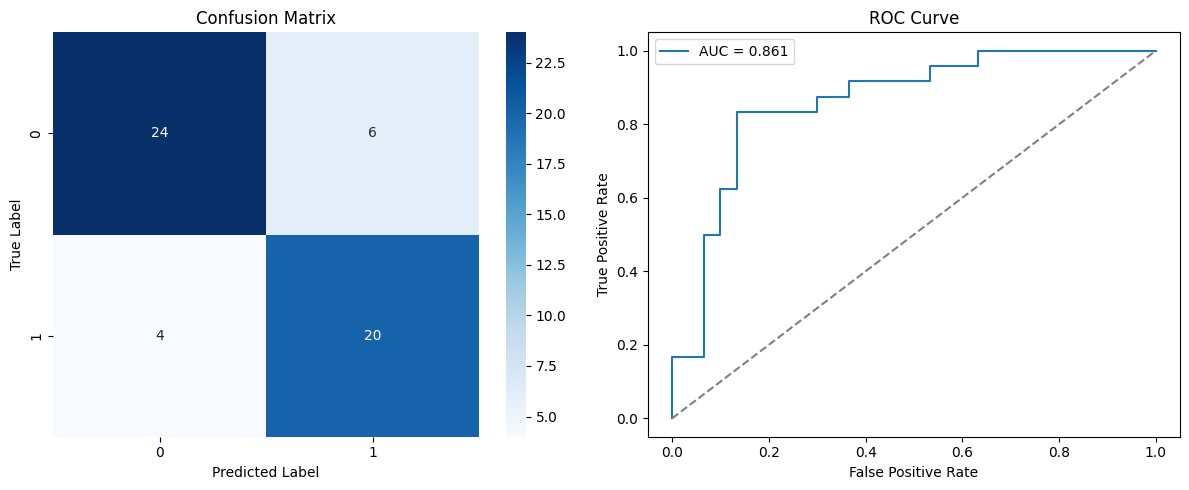

In [69]:
# Confusion Matrix and ROC Curve side by side
cm = confusion_matrix(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# ROC Curve
axes[1].plot(fpr, tpr, label=f"AUC = {auc:.3f}")
axes[1].plot([0,1], [0,1], linestyle='--', color='gray')
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC Curve")
axes[1].legend()

plt.tight_layout()
plt.show()

### Interpretation of XGBoost Classifier with Grid Search

**Best Parameters Found:**
- **learning_rate:** 0.1
- **max_depth:** 5
- **n_estimators:** 200
- **subsample:** 0.8

**Best Cross-Validation F1 Score:** 0.818

These hyperparameters reflect a more complex model with deeper trees (max_depth=5) and a larger number of estimators (200), combined with subsampling to help reduce overfitting.

---

**Test Set Evaluation Metrics:**

- **Accuracy:** 0.815
  - The model correctly classified 81.5% of the test samples.
- **Precision:** 0.769
  - Of all positive predictions, 76.9% were true positives.
- **Recall:** 0.833
  - The model identified 83.3% of actual positive cases.
- **F1 Score:** 0.800
  - Balanced performance between precision and recall.
- **ROC AUC:** 0.861
  - Very good discriminative power.

---

**Confusion Matrix Interpretation:**

|            | Predicted Negative | Predicted Positive |
|------------|--------------------|--------------------|
| **Actual Negative** | 24 (True Negatives) | 6 (False Positives) |
| **Actual Positive** | 4 (False Negatives) | 20 (True Positives) |

- 10 misclassifications out of 54 test samples.
- The recall remained high, though slightly lower than the best Logistic Regression and SVM models.

---

**ROC Curve Interpretation:**
- The ROC curve shows consistent separation between the classes.
- An AUC of 0.861 confirms solid predictive performance.

---

**Comparison to Previous XGBoost Model:**
- The F1 Score remained similar (0.800) despite deeper trees and more estimators.
- The AUC decreased slightly compared to the untuned XGBoost (0.872 vs. 0.861).
- This indicates that increasing model complexity did not significantly improve test performance.

---

**Conclusion:**
This tuned XGBoost model performed similarly to the untuned version, suggesting that the dataset size and feature set do not require very complex boosting configurations. Simpler models like Logistic Regression and SVM are strong baselines and sometimes more stable on small datasets.

## Final Evaluation Report

### Machine Learning Report – Heart Disease Classification

#### Objective

The main objective was to build, compare, and evaluate several machine learning classifiers to predict the presence of heart disease based on clinical variables.

#### Data

- 270 observations
- 14 variables (numerical and categorical)
- Balanced target variable (approximately 55% negative, 45% positive)

#### Models Evaluated

1. Logistic Regression (baseline and Grid Search)
2. Support Vector Machine (baseline and Grid Search)
3. XGBoost (baseline and Grid Search)

#### Key Results

| Model                                    | Accuracy | Precision | Recall | F1 Score | ROC AUC |
|------------------------------------------|:--------:|:---------:|:------:|:--------:|:-------:|
| Logistic Regression (No Grid Search) | 0.870 | 0.815 | **0.917** | 0.863 | 0.893 |
| Logistic Regression (Grid Search)    | 0.833 | 0.778 | 0.917 | 0.824 | **0.906** |
| SVM (No Grid Search)                 | 0.870 | 0.815 | **0.917** | 0.863 | 0.903 |
| SVM (Grid Search)                    | 0.833 | 0.759 | 0.917 | 0.830 | 0.876 |
| XGBoost (No Grid Search)             | 0.815 | 0.769 | 0.833 | 0.800 | 0.872 |
| XGBoost (Grid Search)                | 0.815 | 0.769 | 0.833 | 0.800 | 0.861 |

**Main observations:**
- Logistic Regression and SVM without Grid Search achieved the highest F1 Score (0.863) and Recall (0.917).
- All models had an AUC greater than 0.86, demonstrating strong discriminative power.
- XGBoost did not significantly improve performance over linear models in this dataset.

#### Conclusion

Overall, simpler linear models performed as well or better than more complex models like XGBoost. Logistic Regression and SVM are robust baselines with excellent recall and AUC. For small datasets with balanced classes, simpler models often generalize better.

#### Recommendations

- Deploy Logistic Regression or SVM as a baseline classifier.
- Use cross-validation to validate stability on new data.
- Consider ensemble or calibration methods if further improvements are needed.